## Assignment 11
----

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

### Functions / Classes
-----

In [2]:
def squared_exp(x1, x2, sigma_f=1, l=1):
    return sigma_f*np.exp(-1/(2*l**2)*(x1-x2)**2)

def data_to_vector(x):
    result = list(zip(*product(x, x)))
    return np.array(result[0]), np.array(result[1]),

def construct_posterior_predictive(data_xstar, data_x, data_y, sigma=0.01, sigma_f=1, l=1):
    """
    Returns the mean and covariance for the posterior predictive
    """
    N_star = len(data_xstar)
    N = len(data_x)
    # construct all covariance matrices
    x1, x2 = data_to_vector([*data_x, *data_xstar])
    Cov_mat = squared_exp(x1, x2, sigma_f=sigma_f, l=l).reshape(N_star+N, N_star+N)
    
    # extract the submatrices from Cov_mat
    K_x_x = Cov_mat[:N, :N]
    K_sx_sx =  Cov_mat[N:, N:]
    K_sx_x = Cov_mat[N:, :N]
    K_x_sx = Cov_mat[:N, N:]

    # location of posterior predictive
    mult_factor = np.matmul(K_sx_x, np.linalg.inv(K_x_x + sigma**2*np.identity(N)))
    f_star_bar = mult_factor.dot(data_y)

    cov_f_star = K_sx_sx - np.matmul(mult_factor, K_x_sx)

    return f_star_bar, cov_f_star,

def cholesky_alg(data_xstar, data_x, data_y, noise):
    N_star = 1
    N = len(data_x)
    # construct all covariance matrices
    x1, x2 = data_to_vector([*data_x, data_xstar])
    Cov_mat = squared_exp(x1, x2).reshape(N_star+N, N_star+N)

    K_sx =  Cov_mat[N:, :N]

    L = np.linalg.cholesky(Cov_mat[:N,:N]+noise**2*np.eye(N))
    temp = np.linalg.solve(L, data_y)
    alpha = np.linalg.solve(L.T, temp)

    
    f_star_bar = np.matmul(K_sx, alpha)

    v = np.linalg.solve(L, K_sx.T)

    var_f = Cov_mat[N:,N:] - np.matmul(v.T, v)

    return f_star_bar, var_f,


### Results
----

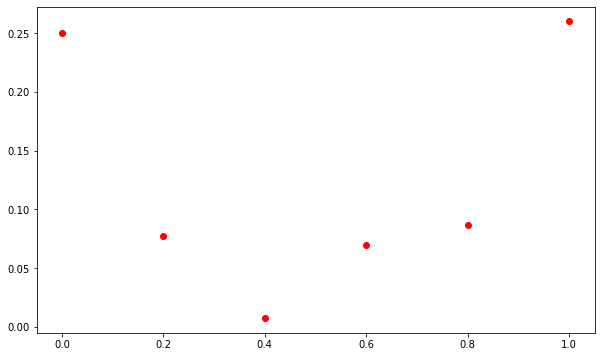

In [3]:
# load / show data
data = [(0.0,0.25),(0.2,0.077),(0.4,0.0075),(0.6,0.07),(0.8,0.087),(1.0,0.26)]

data_x, data_y = list(zip(*data))

data_x = np.array(data_x)
data_y = np.array(data_y)

plt.figure(figsize=(10,6))
plt.plot(data_x, data_y, 'ro');

Contour plots


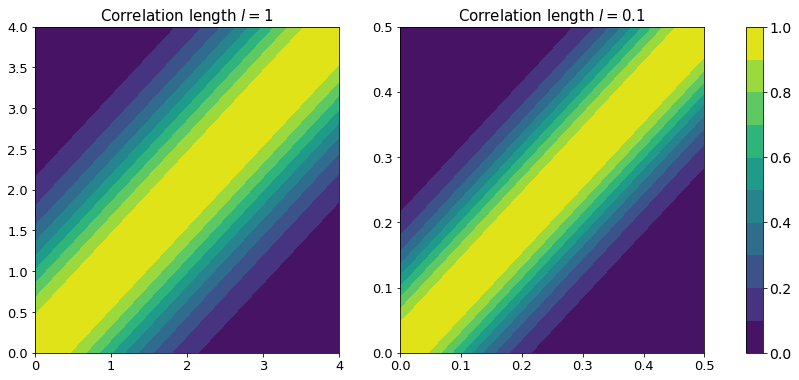

In [9]:
# Data in [0,1] so contour of [0,1] (?)
points2 = np.linspace(0,0.5, 500)
points1 = np.linspace(0,4,500)

# get cov matrices for l=1,l=0.1
x1, x2 = data_to_vector(points1)
x3, x4 = data_to_vector(points2)
cov_mat1 = squared_exp(x1, x2).reshape(500,500)
cov_mat2 = squared_exp(x3, x4, l=0.1).reshape(500,500)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

labels = [1, 0.1]
# plot dings
#plt.suptitle('Contour plots of the squared exponential kernel', fontsize=16)
for i,ax in enumerate([ax1, ax2]):
    ax.tick_params('both', labelsize=13)
    ax.set_title(f'Correlation length $l={labels[i]}$',fontsize=15)

ax1.contourf(points1, points1, cov_mat1, 10, vmin=0, vmax=1);
im = ax2.contourf(points2, points2, cov_mat2, 10, vmin=0, vmax=1);
cbar = plt.colorbar(im, ax=[ax1,ax2]);
cbar.ax.tick_params(labelsize=14) 


Sample from posterior predictive

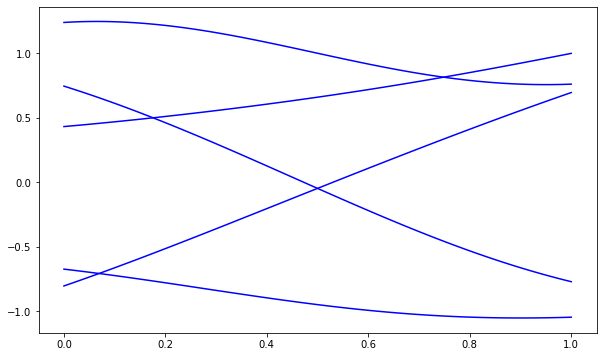

In [13]:
# 100 equidistant sample from kernel
# number of samples
M = 5
x_star = np.linspace(0,1,100)

x1, x2 = data_to_vector(x_star)
cov_mat = squared_exp(x1,x2).reshape(100,100)

plt.figure(figsize=(10,6))
for i in range(M):
    samples = np.random.multivariate_normal([0]*100, cov_mat)

    plt.plot(x_star, samples, 'b-');

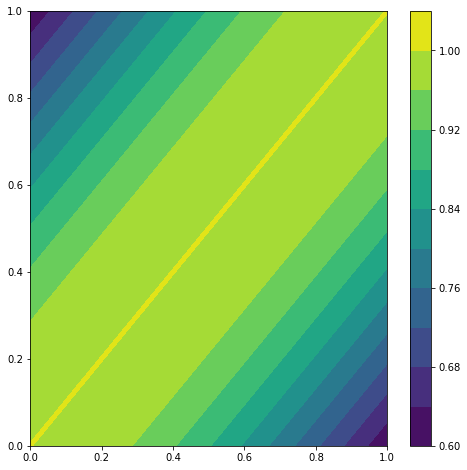

In [20]:
x_star = np.linspace(0,1,100)

x1, x2 = data_to_vector(x_star)
cov_mat = squared_exp(x1,x2).reshape(100,100) + 0.01**2*np.eye(100)

plt.figure(figsize=(8,8))
plt.contourf(x_star, x_star, cov_mat, 10)
plt.colorbar();

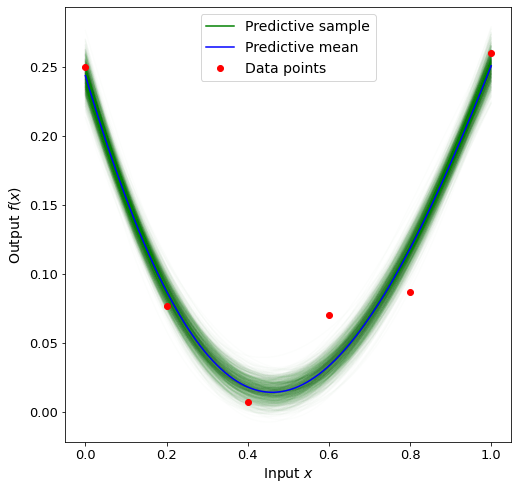

In [11]:
# 1k random samples from posterior predictive distribution
N = 1000
x_star = np.linspace(0,1,100)
f_hat, f_cov = construct_posterior_predictive(x_star, data_x, data_y, sigma=0.01, l=1)

plt.figure(figsize=(8,8))
plt.tick_params('both', labelsize=13);
plt.xlabel('Input $x$', fontsize=14);
plt.ylabel('Output $f(x)$', fontsize=14);

for i in range(N):
    samples = np.random.multivariate_normal(f_hat, f_cov)
  
    plt.plot(x_star, samples, 'g-', alpha=0.01);
# for legend label
plt.plot([.4],[.1], 'g-', label='Predictive sample');
# predictive mean plot
plt.plot(x_star, f_hat, 'b-', label='Predictive mean');

# data points
plt.plot(data_x, data_y, 'ro', label='Data points');
plt.legend(fontsize=14);


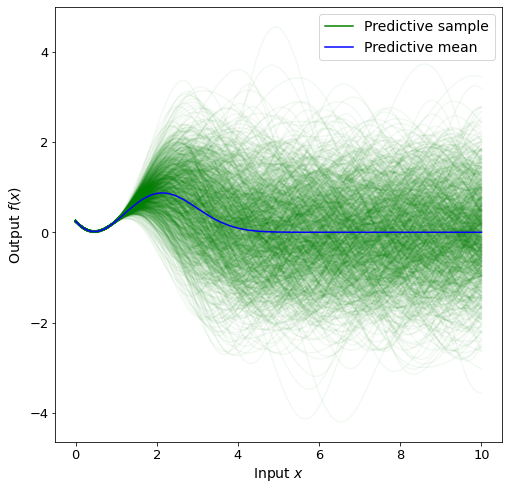

In [10]:
# Extrapolation with posterior predictive
N = 1000
x_star = np.linspace(0,10,100)
f_hat, f_cov = construct_posterior_predictive(x_star, data_x, data_y, sigma=0.01, l=1)

plt.figure(figsize=(8,8))
plt.tick_params('both', labelsize=13);
plt.xlabel('Input $x$', fontsize=14);
plt.ylabel('Output $f(x)$', fontsize=14);
for i in range(N):
    samples = np.random.multivariate_normal(f_hat, f_cov)
 
    plt.plot(x_star, samples, 'g-', alpha=0.05);

# for legend label
plt.plot([.4],[.1], 'g-', label='Predictive sample');

# predictive mean plot
plt.plot(x_star, f_hat, 'b-', label='Predictive mean');

plt.legend(fontsize=14);

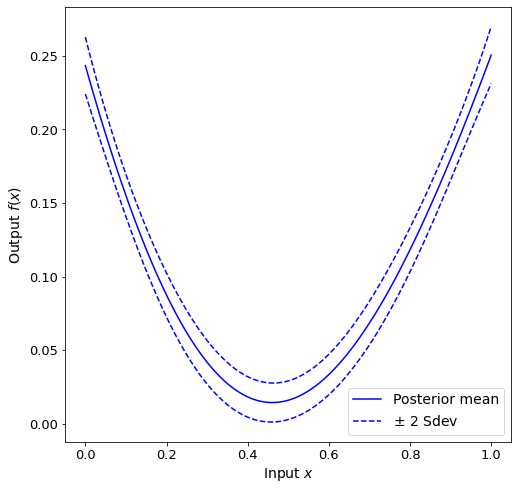

In [17]:
# mean and sdev using Cholesky decomposition alg
points = np.linspace(0,1,100)

f_mean = []
f_var = []
for point in points:
    p_mean, p_var = cholesky_alg(point, data_x, data_y, 0.01)
    f_mean.append(p_mean)
    f_var.append(p_var[0][0])

f_var_plus = [f_mean[i]+2*f_var[i]**(1/2) for i in range(100)]
f_var_min = [f_mean[i]-2*f_var[i]**(1/2) for i in range(100)]

plt.figure(figsize=(8,8))
plt.tick_params('both', labelsize=13);
plt.xlabel('Input $x$', fontsize=14);
plt.ylabel('Output $f(x)$', fontsize=14);

plt.plot(points, f_mean, 'b-', label='Posterior mean');
plt.plot(points, f_var_min, 'b--', label='$\pm$ 2 Sdev');
plt.plot(points, f_var_plus, 'b--');

plt.legend(fontsize=14);

### TESTS
-----

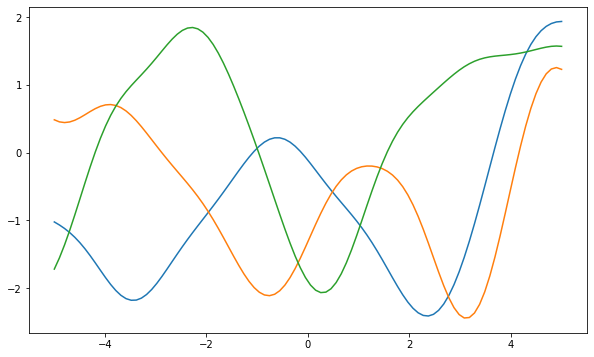

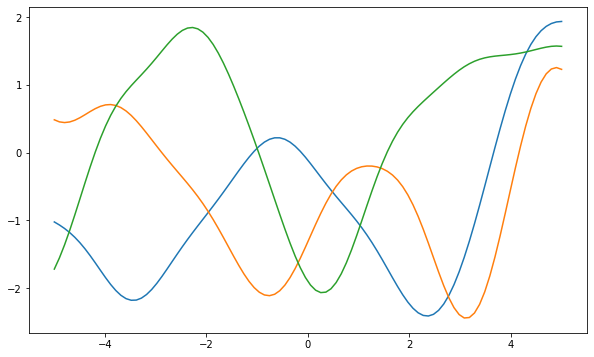

In [12]:
# plot random realisations of GP with squared exponential kernel
plt.figure(figsize=(10,6))
N = 100
rd_sample = np.linspace(-5,5, N)

for j in range(3):
    cov_mat = [[] for i in range(N)]
    for i,x in enumerate(rd_sample):
        for y in rd_sample:
            cov_mat[i].append(squared_exp(x,y))
    np.random.seed(j)
    f_star = np.random.multivariate_normal([0]*N, cov_mat)

    plt.plot(rd_sample, f_star);

# see if same results
plt.figure(figsize=(10,6))
for i in range(3):
    x1, x2 = data_to_vector(rd_sample)
    cov_mat = squared_exp(x1, x2).reshape(N,N)
    np.random.seed(i)
    f_star = np.random.multivariate_normal([0]*N, cov_mat)

    plt.plot(rd_sample, f_star);
    